# Treinamento, teste e avaliação com os imoveis filtrados a venda

## Importação das Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import locale

# Ferramentas do Scikit-learn
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Modelos a serem comparados
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Configurações de Visualização

In [3]:
# Configura o locale para formatar valores em Reais (BRL)
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
    pd.options.display.float_format = 'R$ {:,.2f}'.format
except:
    print("Locale 'pt_BR.UTF-8' não encontrado. Usando locale padrão.")
    pd.options.display.float_format = '{:,.2f}'.format

# Configurações do Seaborn para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Carregar e Preparar os Dados

In [4]:
# Carregar o dataset de venda
try:
    df_venda = pd.read_csv('../Dados/imoveis_venda_filtrado.csv')
    print("Dados de venda carregados com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'imoveis_venda_filtrado.csv' não encontrado.")

print("\nVisão inicial dos dados:")
print(df_venda.head())
print("\nTipos de dados:")
df_venda.info()

Dados de venda carregados com sucesso!

Visão inicial dos dados:
          tipo          bairro     cidade objetivo  area_util  quartos  \
0  apartamento  vila_monumento  são paulo    Venda   R$ 10.00        1   
1  apartamento       liberdade  são paulo    Venda   R$ 32.00        1   
2  apartamento  vila_monumento  são paulo    Venda   R$ 12.00        1   
3  apartamento              se  são paulo    Venda   R$ 29.00        1   
4  apartamento  vila_monumento  são paulo    Venda   R$ 14.00        1   

   suites  vagas         preco  
0       0      0 R$ 133,000.00  
1       0      0 R$ 160,000.00  
2       0      0 R$ 162,000.00  
3       0      0 R$ 170,000.00  
4       0      0 R$ 185,000.00  

Tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6303 entries, 0 to 6302
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tipo       6303 non-null   object 
 1   bairro     6303 non-null   object 
 2   cida

## Engenharia de Features

In [5]:
print("\nIniciando Engenharia de Features...")

# 1. Criar features binárias simples
df_venda['tem_suite'] = (df_venda['suites'] > 0).astype(int)
df_venda['tem_vaga'] = (df_venda['vagas'] > 0).astype(int)

print("Novas features criadas: 'tem_suite', 'tem_vaga'")


Iniciando Engenharia de Features...
Novas features criadas: 'tem_suite', 'tem_vaga'


## Definição de Features (X) e Alvo (y)

In [6]:
# --- Variável Alvo (y) ---

# Aplicar a transformação logarítmica no PRECO. Isso estabiliza a variância e melhora a performance de todos os modelos.
y = np.log1p(df_venda['preco'])

print(f"\nVariável alvo 'y' criada com np.log1p(preco). Média (log): {y.mean():.4f}")

# --- Features (X) ---

# Definir quais colunas serão usadas para prever o preço
features_numericas = [
    'area_util', 
    'quartos', 
    'suites', 
    'vagas',
    # Novas features:
    'tem_suite',
    'tem_vaga'
]

features_categoricas = [
    'tipo',
    'bairro'
]

X = df_venda[features_numericas + features_categoricas]

print("Features (X) e Alvo (y) definidos.")
print(f"Total de features em X: {len(features_numericas)} numéricas e {len(features_categoricas)} categóricas.")


Variável alvo 'y' criada com np.log1p(preco). Média (log): 13.7383
Features (X) e Alvo (y) definidos.
Total de features em X: 6 numéricas e 2 categóricas.


## Divisão em Dados de Treino e Teste

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

Dados divididos: 5042 para treino, 1261 para teste.


## Construção do Pipeline de Pré-processamento

In [8]:
# 1. Pipeline para features numéricas:
#    - StandardScaler: Coloca todas as features na mesma escala (média 0, desvio 1)
# Isso é crucial para modelos como Regressão Linear e evita que features com valores grandes (como 'area_util') dominem as com valores pequenos (como 'quartos').
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 2. Pipeline para features categóricas:
#    - OneHotEncoder: Transforma 'bairro' e 'tipo' em colunas binárias (0 ou 1)
#    - handle_unknown='ignore': Se um bairro novo aparecer nos dados de teste, ele será ignorado sem quebrar o modelo.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Combinar os pipelines com o ColumnTransformer
#    Ele aplicará o transformador correto para a coluna correta.
preprocessor = ColumnTransformer(
    transformers=[
        # ('num', ...): Aplica o 'numeric_transformer' na lista de colunas 'features_numericas'.
        ('num', numeric_transformer, features_numericas),

        # ('cat', ...): Aplica o 'categorical_transformer' na lista 'features_categoricas'.
        ('cat', categorical_transformer, features_categoricas)
    ],
    # remainder='passthrough': Define o que fazer com colunas que NÃO foram listadas em 'features_numericas' ou 'features_categoricas' 'passthrough' significa "mantenha-as como estão".
    remainder='passthrough'
)

print("\nPipeline de pré-processamento (ColumnTransformer) construído.")


Pipeline de pré-processamento (ColumnTransformer) construído.


## Criação dos Pipelines de Modelo Completos

In [25]:
# --- Modelo 1: Regressão Linear ---
# Cria um "Pipeline" (fluxo de trabalho) para o modelo.
pipeline_lr = Pipeline(steps=[
    # Passo 1: Aplicar o 'preprocessor' (StandardScaler + OneHotEncoder) que definimos antes.
    ('preprocessor', preprocessor),
    # Passo 2: Após pré-processar, treinar o modelo de Regressão Linear.
    ('model', LinearRegression())
])

# --- Modelo 2: Random Forest (com parâmetros iniciais) ---
# Cria um segundo pipeline mas com um modelo diferente.
pipeline_rf = Pipeline(steps=[
    # Passo 1: Aplicar o mesmo pré-processador.
    ('preprocessor', preprocessor),
    # Passo 2: Treinar o modelo Random Forest.
    ('model', RandomForestRegressor(
        n_estimators=100, # Define que o modelo usará 100 árvores.
        random_state=42,  # Garante que o resultado seja o mesmo toda vez que rodar.
        n_jobs=-1         # Usa todos os núcleos do processador para treinar mais rápido.
    ))
])

# --- Modelo 3: XGBoost (com parâmetros iniciais) ---
# Cria o terceiro pipeline com o XGBoost
pipeline_xgb = Pipeline(steps=[
    # Passo 1: Aplicar o mesmo pré-processador.
    ('preprocessor', preprocessor),
    # Passo 2: Treinar o modelo XGBoost.
    ('model', XGBRegressor(
        random_state=42, # Garante resultados reprodutíveis.
        n_jobs=-1        # Usa todos os núcleos para acelerar.
    ))
])

# Cria um dicionário chamado 'models' para organizar os pipelines.
# A chave é um nome, e o valor é o objeto do pipeline.
models = {
    'Regressão Linear': pipeline_lr,
    'Random Forest': pipeline_rf,
    'XGBoost': pipeline_xgb
}

print("Pipelines completos (Pré-processamento + Modelo) criados.")

Pipelines completos (Pré-processamento + Modelo) criados.


## Avaliação Base (Cross-Validation)

In [26]:
print("\n--- Iniciando Validação Cruzada (Baseline) ---")
print("Avaliando modelos nos dados de treino (CV=5)...")

# Nota: Usamos 'neg_mean_absolute_error' (Erro Médio Absoluto Negativo) porque a função cross_val_score sempre tenta maximizar uma pontuação. Como queremos minimizar o erro (MAE), usamos a versão negativa dele. O MAE real será o valor *negativo* disso, na escala LOG.

for name, model in models.items():

    # Esta é a função principal: ela executa a Validação Cruzada. Ela pega o 'model', divide 'X_train' e 'y_train' em 5 partes ('cv=5'). Treina em 4 partes e testa em 1, repetindo isso 5 vezes. 'scoring' define a métrica (MAE negativo). 'n_jobs=-1' usa todos os núcleos do processador para rodar mais rápido. 'scores' será uma lista com 5 pontuações (uma para cada fold).
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # Calcula a média das 5 pontuações (ex: -0.21, -0.22, -0.20...). Invertemos o sinal (multiplicamos por -1) para ter o MAE positivo (ex: 0.21). Este é o erro médio do modelo na escala LOG.
    mae_log_mean = -np.mean(scores)
    mae_log_std = np.std(scores)
    
    print(f"Modelo: {name}")
    print(f"  MAE Médio (log): {mae_log_mean:.4f} (std: +/- {mae_log_std:.4f})")

print("--- Validação Cruzada Concluída ---")


--- Iniciando Validação Cruzada (Baseline) ---
Avaliando modelos nos dados de treino (CV=5)...
Modelo: Regressão Linear
  MAE Médio (log): 0.2397 (std: +/- 0.0068)
Modelo: Random Forest
  MAE Médio (log): 0.2299 (std: +/- 0.0101)
Modelo: XGBoost
  MAE Médio (log): 0.2145 (std: +/- 0.0057)
--- Validação Cruzada Concluída ---


## Otimização de Hiperparâmetros (RandomizedSearchCV)

In [27]:
print("\n--- Iniciando Otimização de Hiperparâmetros para XGBoost ---")

# Define os parâmetros que o RandomizedSearchCV irá testar.
param_dist_xgb = {
    
    # 'n_estimators': Número de "árvores" (modelos simples) que o XGBoost irá construir.
    'model__n_estimators': [100, 200, 500, 1000, 1500],
    
    # 'max_depth': A "profundidade" máxima de cada árvore.
    'model__max_depth': [3, 5, 7, 10, 15],
    
    # 'learning_rate': A taxa de aprendizado. É o "tamanho do passo" que o modelo dá para corrigir seus erros a cada nova árvore.
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    
    # 'subsample': A fração de linhas (amostras) do dataset de treino usada para construir cada árvore.
    'model__subsample': [0.7, 0.8, 0.9, 1.0], 
    
    # 'colsample_bytree': A fração de *colunas* (features) usada por cada árvore.
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0] 
}

# Configura o "caçador" de parâmetros (RandomizedSearchCV).
random_search = RandomizedSearchCV(
    
    # 'estimator': O modelo que queremos otimizar.
    estimator=pipeline_xgb,
    
    # 'param_distributions': O "menu" de parâmetros.
    param_distributions=param_dist_xgb,
    
    # 'n_iter': O número de combinações aleatórias de parâmetros que serão testadas.
    n_iter=100, 
    
    # 'cv': O número de "folds" (partes) da Validação Cruzada (Cross-Validation). cv=5 significa que *cada uma* das 100 combinações será treinada/testada 5 vezes
    cv=5,
    
    # 'scoring': A métrica usada para julgar qual combinação é a melhor.
    # 'neg_mean_absolute_error' é usado porque o "caçador" tenta maximizar a pontuação. Ao maximizar o MAE negativo, estamos minimizando o erro.
    scoring='neg_mean_absolute_error',
    
    # 'verbose': O nível de "conversa" do processo. 1 mostra um log de progresso.
    verbose=1,
    
    # 'random_state': Garante que a "aleatoriedade" (quais 100 combinações testar) seja a mesma toda vez que rodarmos o código.
    random_state=42,
    
    # 'n_jobs': O número de núcleos de CPU para usar em paralelo. -1 significa "usar todos os núcleos disponíveis" para rodar o mais rápido possível.
    n_jobs=-1
)

# Inicia a busca.
# O 'random_search' testará as 100 combinações, cada uma com 5 folds (total de 500 treinamentos) para achar a melhor.
random_search.fit(X_train, y_train)

# Após a busca terminar, imprime o vencedor.
print(f"\nMelhores parâmetros encontrados:")
print(random_search.best_params_)

# Salva o melhor pipeline (já treinado nos dados de treino completos com os melhores parâmetros) em uma nova variável.
best_model_xgb = random_search.best_estimator_

# Adiciona este modelo otimizado ao nosso dicionário de modelos para que ele possa ser comparado com os outros.
models['XGBoost (Otimizado)'] = best_model_xgb

print("--- Otimização Concluída ---")


--- Iniciando Otimização de Hiperparâmetros para XGBoost ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Melhores parâmetros encontrados:
{'model__subsample': 0.8, 'model__n_estimators': 1500, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
--- Otimização Concluída ---


## Avaliação Final no Conjunto de Teste

In [28]:
print("\n--- Avaliação Final no Conjunto de Teste ---")

# Antes de testar, devemos treinar os modelos base (não-otimizados)
if 'Regressão Linear' in models:
    models['Regressão Linear'].fit(X_train, y_train)
if 'Random Forest' in models:
    models['Random Forest'].fit(X_train, y_train)
if 'XGBoost' in models:
    models['XGBoost'].fit(X_train, y_train)

print("Modelos base treinados.")

# Cria um dicionário vazio para guardar as previsões
predictions = {}
# Cria uma lista vazia para guardar as métricas (MAE, R²)
results_list = []

# Converter y_test (log) de volta para a escala original (R$)
y_test_original = np.expm1(y_test)

for name, model in models.items():
    
    # 1. Fazer previsão na escala LOG
    y_pred_log = model.predict(X_test)
    
    # 2. Converter previsão de volta para a escala ORIGINAL (R$)
    y_pred_original = np.expm1(y_pred_log)
    
    # Salvar previsões originais
    predictions[name] = y_pred_original
    
    # 3. Calcula as métricas de performance, comparando o Real vs. Previsto.
    
    # MAE (Erro Médio Absoluto): A métrica principal. Diz, em média, "quantos Reais" o modelo errou (para mais ou para menos).
    mae = mean_absolute_error(y_test_original, y_pred_original)

    # R² (R-quadrado): A métrica de "qualidade do ajuste". Diz qual porcentagem da variação dos preços o modelo conseguiu explicar (0 a 1).
    r2 = r2_score(y_test_original, y_pred_original)
    
    # Adiciona os resultados deste modelo na lista.
    results_list.append({'Modelo': name, 'MAE (R$)': mae, 'R²': r2})

# Transforma a lista de resultados em uma tabela (DataFrame) do Pandas.
# Ordena a tabela pelo 'MAE (R$)' (do menor para o maior) para que o melhor modelo apareça primeiro.
df_results = pd.DataFrame(results_list).sort_values(by='MAE (R$)')

print("\nResultados da Avaliação Final (em R$):")

# Imprime a tabela de resultados de forma legível:
# .to_string() -> Converte o DataFrame para texto.
# formatters={...} -> Define a formatação (MAE como "R$ 123.456,78" e R² como "0.745").
# index=False -> Esconde os números de índice (0, 1, 2...) do DataFrame.
print(df_results.to_string(formatters={'MAE (R$)': 'R$ {:,.2f}'.format, 'R²': '{:.3f}'.format}, index=False))


--- Avaliação Final no Conjunto de Teste ---
Modelos base treinados.

Resultados da Avaliação Final (em R$):
             Modelo      MAE (R$)    R²
XGBoost (Otimizado) R$ 256,047.70 0.752
            XGBoost R$ 263,840.04 0.741
      Random Forest R$ 286,515.37 0.691
   Regressão Linear R$ 296,381.87 0.613


## Análise de Importância das Features


--- Análise de Importância das Features (Modelo Otimizado) ---
Top 20 Features Mais Importantes:
                              Feature Importance
                            tem_suite     0.0490
                            tipo_casa     0.0375
                               suites     0.0358
                            area_util     0.0323
                     tipo_apartamento     0.0277
                         bairro_moema     0.0249
           bairro_vila_nova_conceicao     0.0246
                  bairro_indianopolis     0.0206
                  bairro_vila_mariana     0.0193
                    bairro_itaim_bibi     0.0190
         bairro_vila_parque_jabaquara     0.0173
                  bairro_vila_olimpia     0.0169
                bairro_jardim_celeste     0.0164
               bairro_jardim_paulista     0.0151
                     bairro_pinheiros     0.0133
                      bairro_brooklin     0.0130
                bairro_americanopolis     0.0129
                   b

C:\Users\User\AppData\Local\Temp\ipykernel_10164\2028735587.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


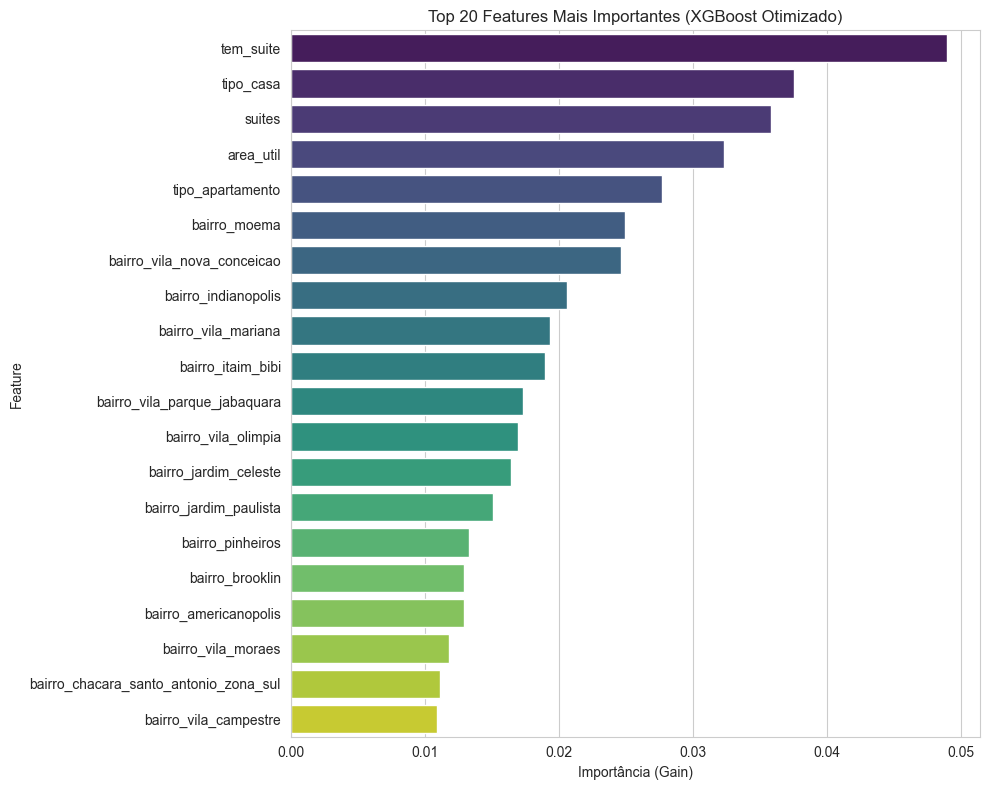

In [ ]:
print("\n--- Análise de Importância das Features (Modelo Otimizado) ---")

try:
    # 1. Pegar o passo de pré-processamento do pipeline
    # Acessa o objeto 'preprocessor' (nosso ColumnTransformer) que está dentro do pipeline final treinado ('best_model_xgb').
    preprocessor_fitted = best_model_xgb.named_steps['preprocessor']
    
    # 2. Pegar o passo do modelo
    # Acessa o objeto 'model' (o XGBRegressor treinado) que está dentro do mesmo pipeline.
    model_fitted = best_model_xgb.named_steps['model']
    
    # 3. Pegar os nomes das features categóricas (criadas pelo OneHotEncoder)
    cat_features_out = (
        preprocessor_fitted.named_transformers_['cat'] # Pega o pipeline de categorias
        .named_steps['onehot'] # Pega o passo 'onehot'
        .get_feature_names_out(features_categoricas) # Pega os nomes gerados
    )
    
    # 4. Combinar todos os nomes de features (numéricas + categóricas)
    # Cria a lista final com TODOS os nomes de features, na mesma ordem que o modelo as recebeu: primeiro as numéricas (ex: 'area_util'), depois as categóricas (ex: 'bairro_moema').
    all_features_out = features_numericas + list(cat_features_out)
    
    # 5. Pegar as importâncias do modelo
    # Extrai a pontuação de importância de cada feature.
    # O XGBoost fornece isso (ex: 'feature_importances_').
    # É uma lista de números (ex: [0.5, 0.1...]) que corresponde, na ordem, à lista 'all_features_out'.
    importances = model_fitted.feature_importances_
    
    # 6. Criar o DataFrame de importância
    # Cria uma tabela (DataFrame) no Pandas, juntando os nomes ('Feature') e as pontuações ('Importance') e ordena da mais importante para a menos importante.
    df_importance = pd.DataFrame({
        'Feature': all_features_out,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("Top 20 Features Mais Importantes:")
    print(df_importance.head(20).to_string(formatters={'Importance': '{:.4f}'.format}, index=False))

    # --- Plotagem do Gráfico ---

    # Cria o gráfico
    plt.figure(figsize=(10, 8))
    # Desenha o gráfico de barras usando o Seaborn.
    # Usa os dados das 20 features mais importantes. x='Importance' (eixo X) e y='Feature' (eixo Y).
    sns.barplot(
        data=df_importance.head(20),
        x='Importance',
        y='Feature',
        palette='viridis' # Define um esquema de cores
    )
    # Adiciona um título ao gráfico.
    plt.title('Top 20 Features Mais Importantes (XGBoost Otimizado)')
    # Rótulo do eixo X. 'Gain' é o tipo de importância que o XGBoost usa.
    plt.xlabel('Importância (Gain)')
    # Rótulo do eixo Y.
    plt.ylabel('Feature')
    # Ajusta o gráfico automaticamente para evitar que os rótulos (nomes) fiquem cortados ou sobrepostos.
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Não foi possível extrair a importância das features: {e}")

## Análise Visual dos Resultados


--- Gerando Gráficos de Dispersão (Previsto vs. Real) ---


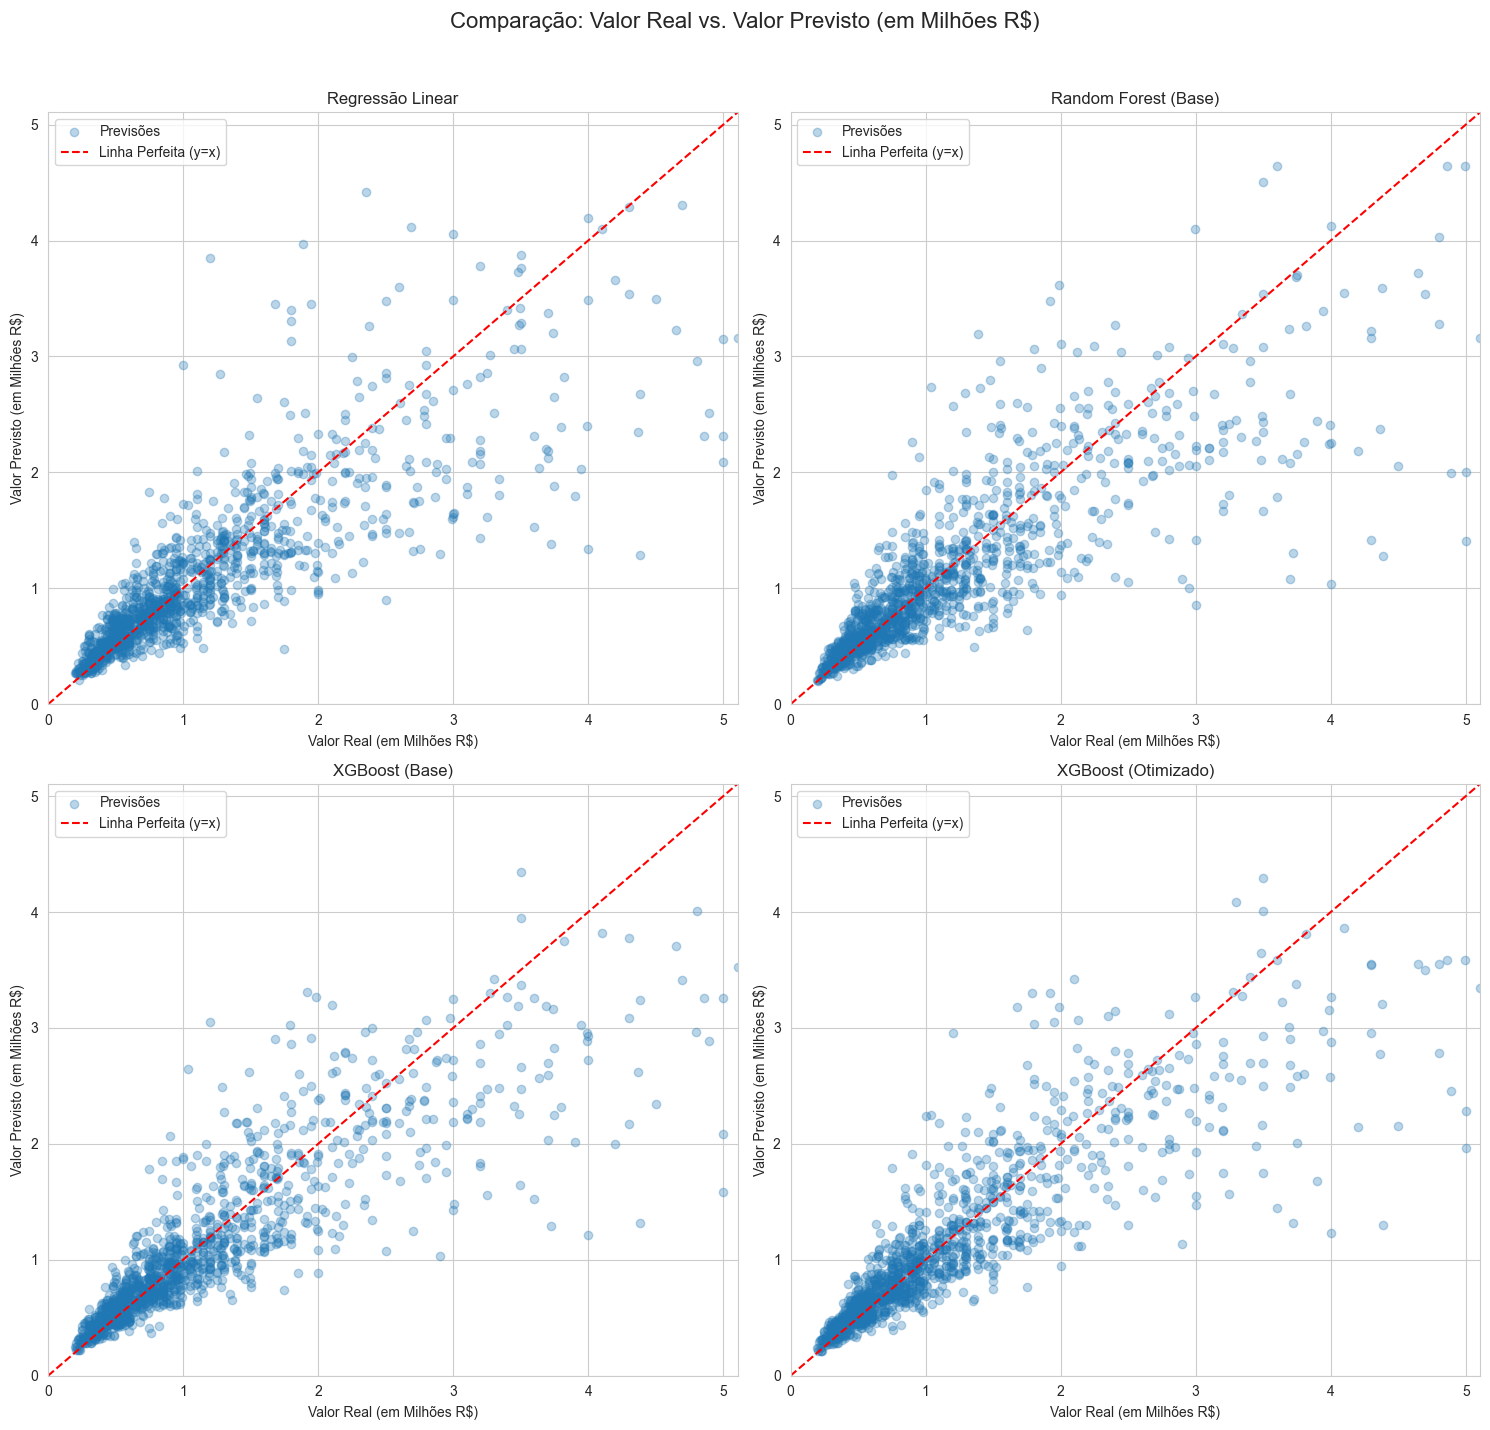


--- Fim da Execução ---


In [30]:
print("\n--- Gerando Gráficos de Dispersão (Previsto vs. Real) ---")

scale = 1e6
label_escala = ' (em Milhões R$)'

# Escalar os dados de teste e previsões
y_test_plot = y_test_original / scale
preds_plot = {name: p / scale for name, p in predictions.items()}

# Definir o limite máximo dos gráficos
plot_limit = y_test_plot.max()
line_data = np.linspace(0, plot_limit, 2)

# Criar a figura
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Comparação: Valor Real vs. Valor Previsto (em Milhões R$)', fontsize=16)

# --- Gráfico 1: Regressão Linear ---
if 'Regressão Linear' in preds_plot:
    ax[0, 0].scatter(y_test_plot, preds_plot['Regressão Linear'], alpha=0.3, label='Previsões')
    ax[0, 0].plot(line_data, line_data, '--r', label='Linha Perfeita (y=x)')
    ax[0, 0].set_title('Regressão Linear')
    ax[0, 0].legend()

# --- Gráfico 2: Random Forest ---
if 'Random Forest' in preds_plot:
    ax[0, 1].scatter(y_test_plot, preds_plot['Random Forest'], alpha=0.3, label='Previsões')
    ax[0, 1].plot(line_data, line_data, '--r', label='Linha Perfeita (y=x)')
    ax[0, 1].set_title('Random Forest (Base)')
    ax[0, 1].legend()

# --- Gráfico 3: XGBoost (Base) ---
if 'XGBoost' in preds_plot:
    ax[1, 0].scatter(y_test_plot, preds_plot['XGBoost'], alpha=0.3, label='Previsões')
    ax[1, 0].plot(line_data, line_data, '--r', label='Linha Perfeita (y=x)')
    ax[1, 0].set_title('XGBoost (Base)')
    ax[1, 0].legend()

# --- Gráfico 4: XGBoost (Otimizado) ---
if 'XGBoost (Otimizado)' in preds_plot:
    ax[1, 1].scatter(y_test_plot, preds_plot['XGBoost (Otimizado)'], alpha=0.3, label='Previsões')
    ax[1, 1].plot(line_data, line_data, '--r', label='Linha Perfeita (y=x)')
    ax[1, 1].set_title('XGBoost (Otimizado)')
    ax[1, 1].legend()

# --- Formatação (aplica a todos os gráficos de uma vez) ---
for eixof in ax.flatten():
    eixof.set_xlabel(f'Valor Real{label_escala}')
    eixof.set_ylabel(f'Valor Previsto{label_escala}')
    # Define os limites de X e Y para serem iguais
    eixof.set_xlim(0, plot_limit)
    eixof.set_ylim(0, plot_limit)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("\n--- Fim da Execução ---")

## Avaliação Final Completa

In [ ]:
from sklearn.metrics import mean_squared_error
# Precisamos do NumPy para a raiz quadrada (sqrt) do RMSE
import numpy as np

print("\n--- Avaliação Final no Conjunto de Teste ---")

# 1. Treinar os modelos base (não-otimizados)
# O 'best_model_xgb' (Otimizado) já foi treinado pelo RandomizedSearch
if 'Regressão Linear' in models:
    print("Treinando Regressão Linear...")
    models['Regressão Linear'].fit(X_train, y_train)
if 'Random Forest' in models:
    print("Treinando Random Forest (Base)...")
    models['Random Forest'].fit(X_train, y_train)
if 'XGBoost' in models:
    print("Treinando XGBoost (Base)...")
    models['XGBoost'].fit(X_train, y_train)

print("Modelos base treinados.")

# --- 2. Preparação para Avaliação ---
predictions = {}
results_list = []

# Converte o "gabarito" (y_test) de log para Reais (R$)
y_test_original = np.expm1(y_test)

# --- 3. Loop de Avaliação ---
# Passa por todos os 4 modelos (LR, RF, XGB, XGB Otimizado)
for name, model in models.items():
    
    print(f"Avaliando modelo: {name}...")
    
    # Prever na escala LOG
    y_pred_log = model.predict(X_test)
    
    # Converter a previsão de volta para Reais (R$)
    y_pred_original = np.expm1(y_pred_log)
    
    # Guardar as previsões (para os gráficos da Célula 13)
    predictions[name] = y_pred_original
    
    # --- 4. Cálculo das Métricas ---
    
    # MAE (Erro Médio Absoluto): Média do erro em Reais. (Quanto menor, melhor)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    # MSE (Erro Quadrático Médio)
    mse = mean_squared_error(y_test_original, y_pred_original)
    
    # RMSE (Raiz do Erro Quadrático Médio): Métrica de erro em Reais, que penaliza mais os erros grandes. (Quanto menor, melhor)
    rmse = np.sqrt(mse)
    
    # R² (R-quadrado): Porcentagem da variação dos preços que o modelo conseguiu explicar. (Quanto mais perto de 1.0, melhor)
    r2 = r2_score(y_test_original, y_pred_original)
    
    # Adiciona todas as métricas na lista de resultados
    results_list.append({
        'Modelo': name, 
        'MAE (R$)': mae, 
        'RMSE (R$)': rmse, 
        'R²': r2
    })

# --- 5. Apresentação dos Resultados ---

# Cria o DataFrame final com os resultados
df_results = pd.DataFrame(results_list).sort_values(by='MAE (R$)')

print("\nResultados da Avaliação Final (em R$):")

# Imprime a tabela formatada, agora incluindo o RMSE
print(df_results.to_string(
    formatters={
        'MAE (R$)': 'R$ {:,.2f}'.format,
        'RMSE (R$)': 'R$ {:,.2f}'.format, # <-- Formatação do RMSE
        'R²': '{:.3f}'.format
    }, 
    index=False
))


--- Avaliação Final no Conjunto de Teste ---
Treinando Regressão Linear...
Treinando Random Forest (Base)...
Treinando XGBoost (Base)...
Modelos base treinados.
Avaliando modelo: Regressão Linear...
Avaliando modelo: Random Forest...
Avaliando modelo: XGBoost...
Avaliando modelo: XGBoost (Otimizado)...

Resultados da Avaliação Final (em R$):
             Modelo      MAE (R$)     RMSE (R$)    R²
XGBoost (Otimizado) R$ 256,047.70 R$ 440,844.90 0.752
            XGBoost R$ 263,840.04 R$ 451,324.96 0.741
      Random Forest R$ 286,515.37 R$ 492,879.16 0.691
   Regressão Linear R$ 296,381.87 R$ 551,216.70 0.613
